# Basic SIR example
Sean L. Wu (@slwu89), 2021-1-8

In [1]:
using individual.sampling
using individual.schema_base

using Catlab.Present, Catlab.CSetDataStructures, Catlab.Theories, Catlab.CategoricalAlgebra, Catlab.Graphics, Catlab.Graphs
using Plots, GraphViz

## Introduction
The SIR (Susceptible-Infected-Recovered) model is the "hello, world!" model of for infectious disease simulations,
and here we describe how to use the basic schema for Markov models to build it in individual.jl. We only use the
base `TheoryIBM` schema, because the model is a Markov chain. This tutorial largely mirrors the SIR model tutorial from
the [R package "individual"](https://mrc-ide.github.io/individual/articles/Tutorial.html), which inspired individual.jl.

The schema looks like this:

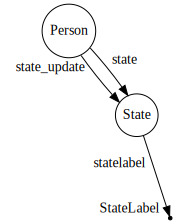

In [2]:
to_graphviz(TheoryIBM)

There are morphisms from the set `Person` into `State`. The first, `state` gives the current state of each individual in the
simulation. The second `state_update` is where state updates can be queued; at the end of a time step, `state` is swapped
with `state_update` and `state_update` is reset. This ensures that state updates obey a FIFO order, and that individuals
update synchronously.

There is also a set of labels for states to make it easier to write self-documenting models.

The basic schema could be extended with further `Attr`s if needing to model individual level heterogeneity, like immmune respose, etc.

## Parameters

To start, we should define some parameters. The epidemic will be simulated in a population of 1000, where 5 persons are initially infectious, whose indices are randomly sampled.
The effective contact rate β will be a function of the deterministic R0 and recovery rate γ. We also specify dt, which is the size of the time step (Δt).
Because individual’s time steps are all of unit length, we scale transition probabilities by dt to create models with different sized steps, interpreting the discrete time model as a discretization of a continuous time model.
If the maximum time is tmax then the overall number of time steps is tmax/dt.

In [3]:
N = 1000
I0 = 5
S0 = N - I0
Δt = 0.1
tmax = 100
steps = Int(tmax/Δt)
γ = 1/10 # recovery rate
R0 = 2.5
β = R0 * γ # R0 for corresponding ODEs

initial_states = fill(1, N)
initial_states[rand(1:N, I0)] .= 2
state_labels = ["S", "I", "R"]

# # Model object

const SIR = IBM{String}()
add_parts!(SIR, :State, length(state_labels), statelabel = state_labels)
people = add_parts!(SIR, :Person, N)
set_subpart!(SIR, people, :state, initial_states)

# # Processes

1000-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 ⋮
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  991, 992, 993, 994, 995, 996, 997, 998, 999, 1000]
 [1,

In order to model infection, we need a process. This is a function that takes only a single argument, `t``, for the current time step (unused here, but can model time-dependent processes, such as seasonality or school holiday).
Within the function, we get the current number of infectious individuals, then calculate the per-capita force of infection on each susceptible person, λ=βI/N.
Next we get the set of susceptible individuals and use the sample method to randomly select those who will be infected on this time step.
The probability is given by $$ 1- e^{-\lambda \Delta t} $$. The method `bernoulli_sample` will automatically calculate that probability when given 3 arguments. Finally, we queue a state update for those individuals who were sampled.

In [4]:
function infection_process(t::Int)
    I = npeople(SIR, "I")
    N = npeople(SIR)
    λ = β * I/N
    S = get_index_state(SIR, "S")
    S = bernoulli_sample(S, λ, Δt)
    queue_state_update(SIR, S, "I")
end

infection_process (generic function with 1 method)

The recovery process is simpler, as the per-capita transition probability from I to R does not depend on the state of the system.

In [5]:
function recovery_process(t::Int)
    I = get_index_state(SIR, "I")
    I = bernoulli_sample(I, γ, Δt)
    queue_state_update(SIR, I, "R")
end

# # Simulation

recovery_process (generic function with 1 method)

We run a simulation and plot the results.

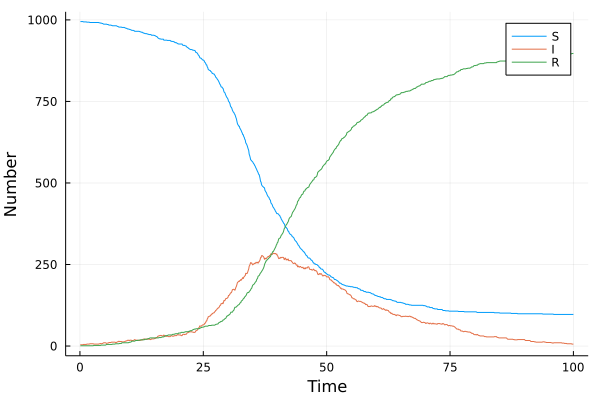

In [6]:
out = Array{Int64}(undef, steps, 3)

for t = 1:steps
    infection_process(t)
    recovery_process(t)
    out[t, :] = output_states(t, SIR)
    apply_state_updates(SIR)
end

plot(
    (1:steps) * Δt,
    out,
    label=["S" "I" "R"],
    xlabel="Time",
    ylabel="Number"
)